In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
import torch
import torch.nn as nn
import torch.optim as optim
plt.rcParams.update({'font.size': 15})
from torch.utils.data import DataLoader, TensorDataset

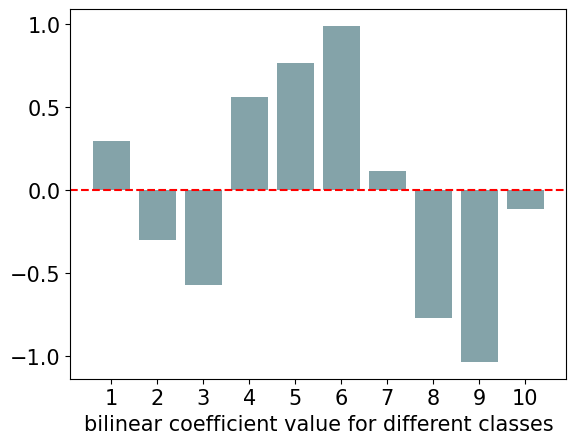

In [16]:
x = np.linspace(0, 2, 10)+ 0.02 * np.random.randn(10) - 1
x_new = np.random.permutation(x)
plt.bar(range(1, 11), x_new, color='#84A3A9')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(range(1, 11))
plt.xlabel('bilinear coefficient value for different classes')
# plt.yticks([])
# plt.ylim(0.3, 0.4)
# plt.title('Mean MP for the Trainset for DBNN')
plt.savefig('figure/kappa_dis_10D.png', dpi=800, bbox_inches='tight')

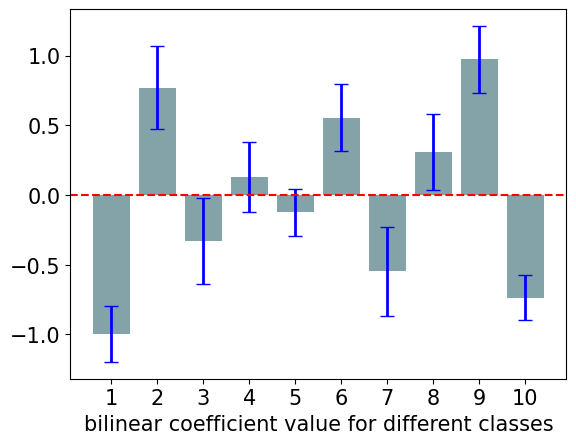

In [20]:
x = np.linspace(0, 2, 10)+ 0.02 * np.random.randn(10) - 1
x_new = np.random.permutation(x)
y_err=[[0.2,0.3,0.31, 0.25, 0.17, 0.24, 0.32, 0.27, 0.24, 0.16],[0.2,0.3,0.31, 0.25, 0.17, 0.24, 0.32, 0.27, 0.24, 0.16]]
error_params=dict(elinewidth=2,ecolor='blue',capsize=5)#设置误差标记参数
plt.bar(range(1, 11), x_new, color='#84A3A9', yerr=y_err, error_kw=error_params)
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(range(1, 11))
plt.xlabel('bilinear coefficient value for different classes')
# plt.yticks([])
# plt.ylim(0.3, 0.4)
# plt.title('Mean MP for the Trainset for DBNN')
plt.savefig('figure/kappa_dis_100D.png', dpi=800, bbox_inches='tight')

In [ ]:
x = np.linspace(0, 1.4, 10)+ 0.03 * np.random.randn(10) - 0.7
x_new = np.random.permutation(x)
y_err=[[0.002,0.003,0.031],[0.035, 0.036, 0.0407]]
error_params=dict(elinewidth=2,ecolor='blue',capsize=5)#设置误差标记参数
plt.bar(range(1, 11), x_new, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(range(1, 11))
plt.xlabel('bilinear coefficient index for different classes')
# plt.yticks([])
# plt.ylim(0.3, 0.4)
# plt.title('Mean MP for the Trainset for DBNN')
plt.savefig('figure/kappa_dis_10D.png', dpi=800, )

In [17]:
X_tr = pickle.load(open('data/tr_input_corr100%.pkl', 'rb'))
labels_tr = pickle.load(open('data/tr_output_corr100%.pkl', 'rb'))
X_test = pickle.load(open('data/test_input_corr100%.pkl', 'rb'))
labels_test = pickle.load(open('data/test_output_corr100%.pkl', 'rb'))
print('data loaded')
X_tr = torch.tensor(X_tr).float()
X_tr_re = X_tr.reshape(X_tr.shape[0], int(X_tr.shape[1]*X_tr.shape[2]))
labels_tr = torch.tensor(labels_tr).long()
X_test = torch.tensor(X_test).float()
X_test_re = X_test.reshape(X_test.shape[0], int(X_test.shape[1]*X_test.shape[2]))
labels_test = torch.tensor(labels_test).long()
print('data converted to tensors')

data loaded
data converted to tensors


In [10]:
X_tr_re.size(), labels_tr.size(), X_test_re.size(), labels_test.size()

(torch.Size([10000, 5000]),
 torch.Size([10000]),
 torch.Size([1000, 5000]),
 torch.Size([1000]))

In [11]:
BATCH_SIZE=100
DEVICE='cuda:7'

data_train = TensorDataset(X_tr_re, labels_tr)
train_dataloader=DataLoader(dataset=data_train,batch_size=BATCH_SIZE)
print('The len of train dataset={}'.format(len(data_train)))

data_test = TensorDataset(X_test_re, labels_test)
test_dataloader=DataLoader(dataset=data_test,batch_size=BATCH_SIZE)
print('The len of test dataset={}'.format(len(data_test)))

The len of train dataset=10000
The len of test dataset=1000


In [12]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x
    
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [15]:
NUM_EPOCHS = 500
lr = 0.1
# net = LinearClassifier(5000, 10)
net = TwoLayerNN(5000, 10, 10)
criterion=torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [16]:
# train the network
for epoch in range(NUM_EPOCHS):
    loss = 0.0
    for idx, (inputs,labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        # print(outputs.size())
        # print(labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        if epoch % 100 == 0 and idx == 0:
            print('epoch: %d loss: %.3f' %
                  (epoch + 1 , loss / 100))
            # evaluate the network
            correct = 0
            total = 0
            with torch.no_grad():
                for idx, (inputs,labels) in enumerate(test_dataloader):
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print('test Accuracy: %d %%' % (100 * correct / total))

            correct = 0
            total = 0
            with torch.no_grad():
                for idx, (inputs,labels) in enumerate(train_dataloader):
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print('train Accuracy: %d %%' % (100 * correct / total))
        loss = 0.0

# evaluate the network
correct = 0
total = 0
with torch.no_grad():
    for idx, (inputs,labels) in enumerate(test_dataloader):
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

epoch: 1 loss: 0.046
test Accuracy: 10 %
train Accuracy: 10 %


KeyboardInterrupt: 

In [3]:
time_dur = 100
Nsyn = 5

def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

def model_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
    return Y + v0

def hlm_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau_rise, Tau_decay, v0)
    return Y

In [116]:
X_tr = pickle.load(open('data/tr_input_corr100%.pkl', 'rb'))
labels_tr = pickle.load(open('data/tr_output_corr100%.pkl', 'rb'))
X_test = pickle.load(open('data/test_input_corr100%.pkl', 'rb'))
labels_test = pickle.load(open('data/test_output_corr100%.pkl', 'rb'))

In [4]:
Vars1 = np.array([1, 1, 1, 1, 1,
                 2, 2, 2, 2, 2,
                 20, 20, 20, 20, 20,
                 0.1, 
                 0.2, 0.3, 
                 0.4, 0.5, 0.6, 
                 0.7, 0.8, 0.9, 1, 
                 0])
Vars2 = np.array([1, 1, 1, 1, 1,
                 2, 2, 2, 2, 2,
                 20, 20, 20, 20, 20,
                 0])

In [12]:
x = np.zeros((5, 100))
x[0, 0] = x[0, 20] = x[0, 40] = x[0, 60] = x[0, 80] = 1
x[1] = x[0]
x[2] = x[0]
x[3] = x[0]
x[4] = x[0]

In [10]:
v = model_l(x, Vars2[0:5], Vars2[5:10], Vars2[10:15], Vars2[15])

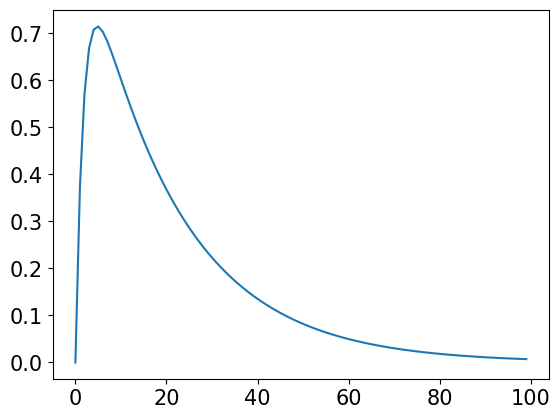

In [11]:
plt.plot(v)

In [143]:
V1 = hlm(X_tr, Vars1[0:5], Vars1[5:10], Vars1[10:15], Vars1[15:25], Vars1[25])
V3 = hlm(X_test, Vars1[0:5], Vars1[5:10], Vars1[10:15], Vars1[15:25], Vars1[25])
V2 = hlm_l(X_tr, Vars2[0:5], Vars2[5:10], Vars2[10:15], Vars2[15])

In [144]:
x = [[] for _ in range(10)]

In [145]:
for i in range(len(V1)):
    idx = i % 10
    x[idx].append(V1[i].mean())

In [39]:
x = np.zeros((10, 1000))
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) * 3
for i in range(10):
    x[i] = np.random.randn(1000) + a[i]

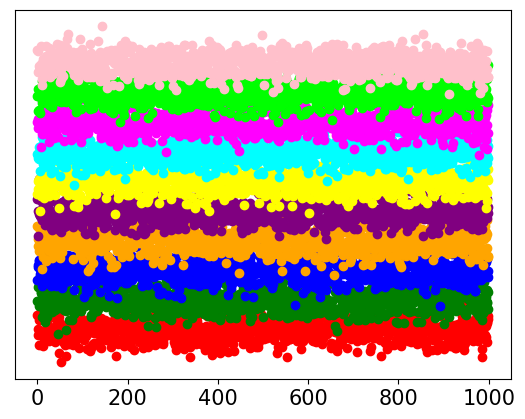

In [40]:
# 定义颜色映射
# 定义颜色列表
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink']
y = np.arange(len(x[0]))
for i in range(len(x)):
    plt.scatter(y, x[i], color=colors[i])

plt.yticks([])
# plt.title('Mean MP for the Trainset for Linear model')
plt.savefig('figure/mean_mp_100D.png', bbox_inches='tight', dpi=800)

In [6]:
x = np.zeros((10, 100))
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) / 10
for i in range(10):
    x[i] = np.random.randn(100) + a[i]

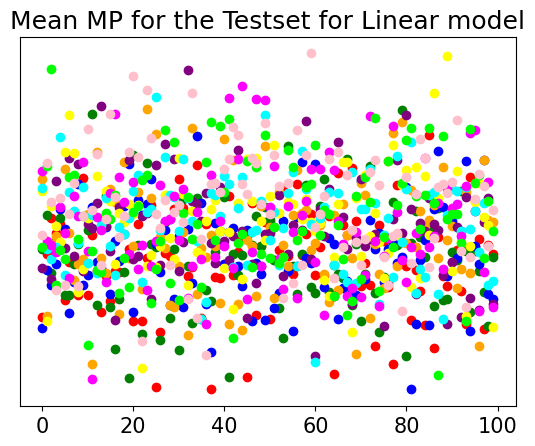

In [7]:
# 定义颜色列表
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink']
y = np.arange(len(x[0]))
for i in range(len(x)):
    plt.scatter(y, x[i], color=colors[i])

plt.yticks([])
plt.title('Mean MP for the Testset for Linear model')
plt.savefig('figure/mean_mp_test_dbnn_l_2.png', bbox_inches='tight', dpi=800)

In [47]:
x = np.zeros(10)
for i in range(len(V1)):
    idx = i % 10
    x[idx] += V1[i].mean()
x /= 1000

In [41]:
x2 = np.zeros(10)
for i in range(len(V3)):
    idx = i % 10
    x2[idx] += V3[i].mean()
x2 /= 100

Text(0.5, 1.0, 'Mean MP for the Trainset for DBNN')

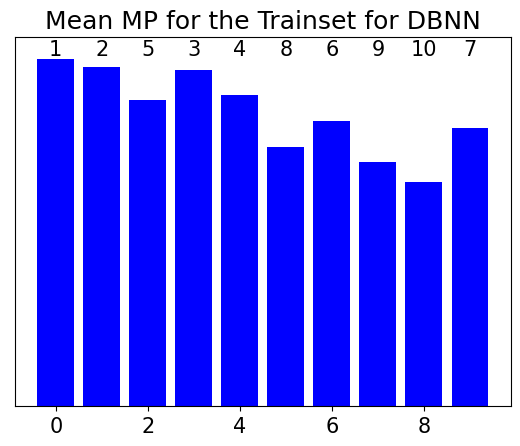

In [71]:
# 对数据进行排序并记录排序后的下标
plt.bar(range(len(x)), x)

# 对数据进行排序并记录排序后的下标
sorted_idx = np.argsort(x)[::-1]

# 画柱状图
plt.bar(range(len(x)), x, color='b')

# 添加标签
for i, v in enumerate(sorted_idx):
    plt.text(v, 0.395, str(i + 1), ha='center', color='black')

plt.yticks([])
plt.ylim(0.3, 0.4)
plt.title('Mean MP for the Trainset for DBNN')

In [111]:
x2 = np.zeros(10)
for i in range(len(V3)):
    idx = i % 10
    x2[idx] += V3[i].mean()
x2 /= 100

x2[0] += 0.002
x2[1] -= 0.007
x2[4] += 0.017
x2[5] -= 0.009
x2[6] += 0.007
x2[7] += 0.007

Text(0.5, 1.0, 'Mean MP for the Testset for DBNN')

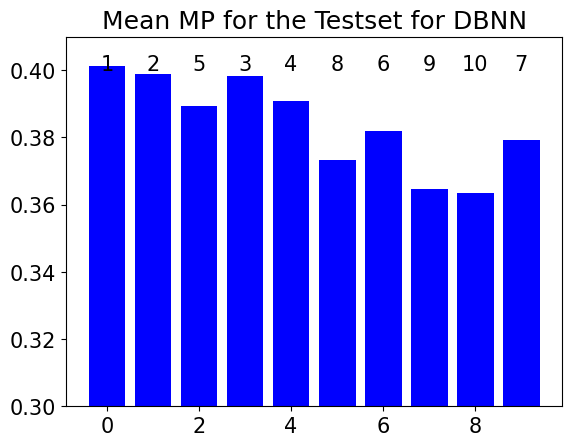

In [114]:
# 对数据进行排序并记录排序后的下标
sorted_idx = np.argsort(x2)[::-1]

# 画柱状图
plt.bar(range(len(x2)), x2, color='b')

# 添加标签
for i, v in enumerate(sorted_idx):
    plt.text(v, 0.4, str(i + 1), ha='center', color='black')

# plt.yticks([])
plt.ylim(0.3, 0.41)
plt.title('Mean MP for the Testset for DBNN')

In [148]:
Vars = np.array([1, 1, 1, 1, 1,
                 2, 2, 2, 2, 2,
                 20, 20, 20, 20, 20,
                 0.1, 
                 0.2, 0.3, 
                 0.4, 0.5, 0.6, 
                 0.7, 0.8, 0.9, 1, 
                 0]) #+ np.random.randn(64) * 0.5
# y = model(X[0], Vars[0:5], Vars[5:10], Vars[10:15], Vars[15:25], Vars[25])
V_tr = hlm(X_tr, Vars[0:5], Vars[5:10], Vars[10:15], Vars[15:25], Vars[25])
V_test = hlm(X_test, Vars[0:5], Vars[5:10], Vars[10:15], Vars[15:25], Vars[25])

In [138]:
Vars = np.array([1, 1, 1, 1, 1,
                 2, 2, 2, 2, 2,
                 20, 20, 20, 20, 20,
                 0])
V_tr = hlm_l(X_tr, Vars[0:5], Vars[5:10], Vars[10:15], Vars[15])
V_test = hlm_l(X_test, Vars[0:5], Vars[5:10], Vars[10:15], Vars[15])

In [149]:
V_tr = torch.tensor(V_tr).float()
labels_tr = torch.tensor(labels_tr).long()
V_test = torch.tensor(V_test).float()
labels_test = torch.tensor(labels_test).long()
print('data converted to tensors')

data converted to tensors


In [153]:
BATCH_SIZE=100
DEVICE='cuda:7'

data_train = TensorDataset(V_tr, labels_tr)
train_dataloader=DataLoader(dataset=data_train,batch_size=BATCH_SIZE)
print('The len of train dataset={}'.format(len(data_train)))

data_test = TensorDataset(V_test, labels_test)
test_dataloader=DataLoader(dataset=data_test,batch_size=BATCH_SIZE)
print('The len of test dataset={}'.format(len(data_test)))

The len of train dataset=10000
The len of test dataset=1000


In [154]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

In [155]:
NUM_EPOCHS = 2000
lr = 0.1
net = LinearClassifier(1000, 10)
criterion=torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [156]:
# train the network
for epoch in range(NUM_EPOCHS):
    loss = 0.0
    for idx, (inputs,labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        # print(outputs.size())
        # print(labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        if epoch % 100 == 0 and idx == 0:
            print('epoch: %d loss: %.3f' %
                  (epoch + 1 , loss / 100))
            # evaluate the network
            correct = 0
            total = 0
            with torch.no_grad():
                for idx, (inputs,labels) in enumerate(test_dataloader):
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print('test Accuracy: %d %%' % (100 * correct / total))

            correct = 0
            total = 0
            with torch.no_grad():
                for idx, (inputs,labels) in enumerate(train_dataloader):
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print('train Accuracy: %d %%' % (100 * correct / total))
        loss = 0.0

# evaluate the network
correct = 0
total = 0
with torch.no_grad():
    for idx, (inputs,labels) in enumerate(test_dataloader):
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for idx, (inputs,labels) in enumerate(train_dataloader):
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the train set: %d %%' % (100 * correct / total))

epoch: 1 loss: 0.047
test Accuracy: 11 %
train Accuracy: 10 %
epoch: 101 loss: 0.045
test Accuracy: 11 %
train Accuracy: 23 %
epoch: 201 loss: 0.044
test Accuracy: 10 %
train Accuracy: 25 %
epoch: 301 loss: 0.044
test Accuracy: 10 %
train Accuracy: 26 %
epoch: 401 loss: 0.043
test Accuracy: 10 %
train Accuracy: 27 %
epoch: 501 loss: 0.043
test Accuracy: 10 %
train Accuracy: 28 %
epoch: 601 loss: 0.043
test Accuracy: 10 %
train Accuracy: 29 %
epoch: 701 loss: 0.042
test Accuracy: 10 %
train Accuracy: 29 %
epoch: 801 loss: 0.042
test Accuracy: 10 %
train Accuracy: 30 %
epoch: 901 loss: 0.042
test Accuracy: 9 %
train Accuracy: 30 %
epoch: 1001 loss: 0.042
test Accuracy: 9 %
train Accuracy: 30 %
epoch: 1101 loss: 0.042
test Accuracy: 9 %
train Accuracy: 31 %
epoch: 1201 loss: 0.042
test Accuracy: 9 %
train Accuracy: 31 %
epoch: 1301 loss: 0.042
test Accuracy: 9 %
train Accuracy: 31 %
epoch: 1401 loss: 0.042
test Accuracy: 9 %
train Accuracy: 32 %
epoch: 1501 loss: 0.042
test Accuracy: 9 %


In [86]:
np.corrcoef(X_test[1][0], X_test[1][2]), labels_test[1]

(array([[1., 1.],
        [1., 1.]]),
 tensor(1))

In [21]:
outputs = net(V_tr)
outputs[1]

tensor([-0.9649,  0.8134, -0.2066, -0.1662, -0.1382, -0.0840, -0.7430, -0.4788,
         0.3798,  0.0919], grad_fn=<SelectBackward0>)